# Signal Processing
## Week \#6 Lab: FIR Filter Design

### Introduction

Finite-duration impulse response (FIR) filters involve finding a polynomial frequency response function to approximate the design specifications. This is in contrast to IIR filters, which require a rational approximating function. Therefore, the algorithms used for FIR filter design are different. In this lab, we consider two common approaches to FIR filter design. First, a simple method to achieve an FIR filter is to truncate an IIR impulse response using a window function. This design technique for FIR filters using a rectangular window can lead to large ripples in the passband and stopband so other windows are generally used to reduce the ripples. The second method we consider in the exercise for you to complete is the optimum equiripple design known as the Parks-McClellan algorithm.

### Install Python Packages

Import the necessary Python modules to implement the lab.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import signal

### User-Defined Functions

Below, we define a function to create a pole-zero plot for a discrete-time system.

In [2]:
# user-defined function for pole-zero plot given the a and b coefficients
def PoleZeroPlot(b, a):
    (zeros, poles, gain) = signal.tf2zpk(b, a)
    angle = np.linspace(-np.pi, np.pi, 50)
    cirx = np.sin(angle)
    ciry = np.cos(angle)
    fig, ax = plt.subplots(figsize = (8,8))
    ax.plot(poles.real, poles.imag, 'kx', zeros.real, zeros.imag, 'ko',markerfacecolor='none')
    ax.plot(cirx, ciry, 'k-')
    ax.axhline(color='black')
    ax.axvline(color='black')
    ax.set_aspect('equal')
    ax.set_xlim((-2,2))
    ax.set_xlabel('Real')
    ax.set_ylabel('Imaginary')
    ax.grid()
    ax.set_title("Pole-Zero Plot")
    return (zeros, poles, gain)

### FIR Filter Design Using Windows

In this example, we design a digital FIR lowpass filter using a Kaiser window and consider its performance with two single-frequency components. You can try different amplitudes for the frequency component in the stopband to investigate how the filter performs. We use the __[`scipy.signal.kaiserord`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.kaiserord.html)__ function to determine the length of the FIR filter required (number of coefficients) given the maximum allowable passband ripple and transition bandwidth. The __[`scipy.signal.firwin`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html)__ function computes the filter coefficients (impulse response).

- passband cutoff frequency = 100 Hz
- stopband cutoff frequency = 150 Hz
- minimum desired stopband attenuation = 60 dB

The first magnitude response plot uses normalized frequency, zero to 1, where 1 represents half the sample frequency. Using the sampling frequency, the second magnitude plot converts the normalized frequency to the continuous-time signal frequency in Hz. The phase plot shows the resulting linear phase response from an FIR filter design and uses the unwrap command to shift from the principle phase to the continuous phase. The remaining discontinuities of $\pi$ correspond to each zero at which the zero-phase response alternates sign. A pole-zero plot emphasizes that the FIR filter is an all-zero filter (notice the zeros on the unit circle that correspond to the stopband). The filtering is implemented with __[`scipy.signal.lfilter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html)__.

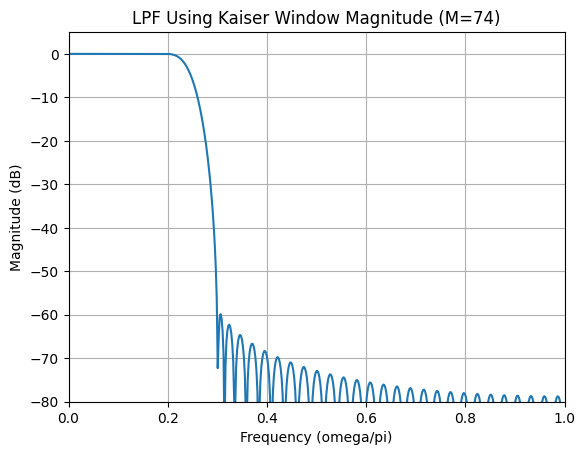

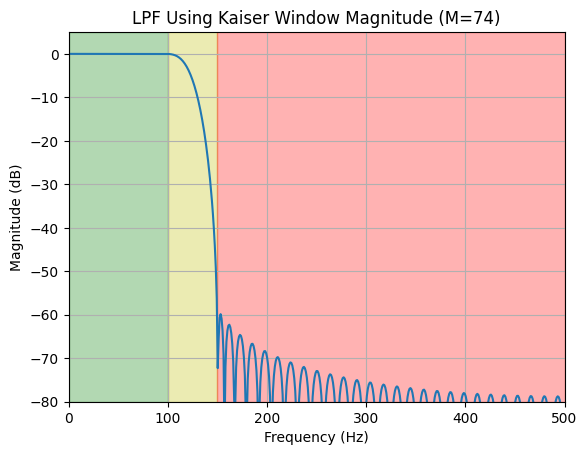

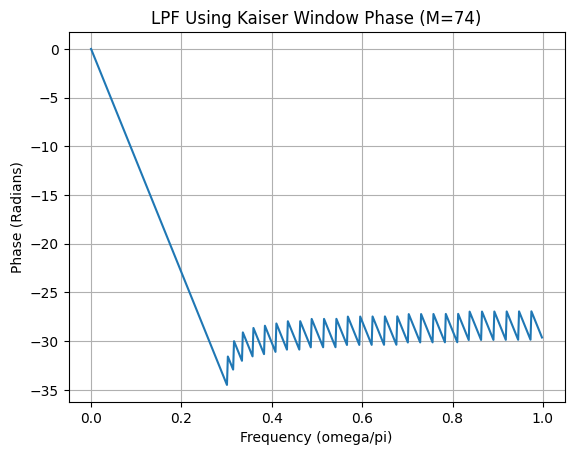

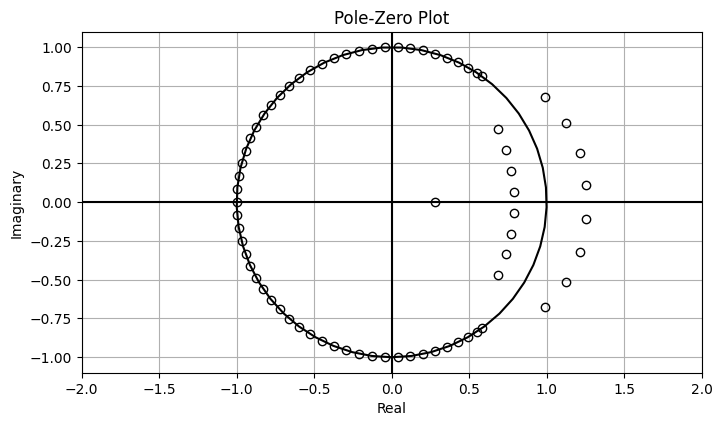

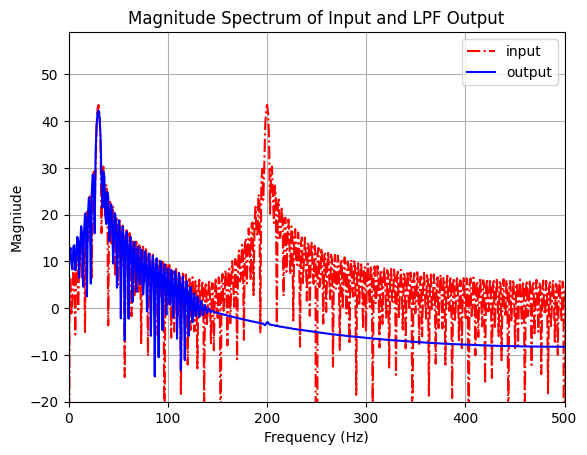

In [3]:
# Create filter specifications

Fs = 1000 # sample rate (Hz)
fpass = 100 # passband cutoff (Hz)
fstop = 150 # stopband cutoff (Hz)
fc = 125 # lowpass cutoff frequency (Hz)
deltadB = 60 # minimum desired attenuation in stopband (dB)

# Design FIR Filter
M, beta = signal.kaiserord(deltadB, (fstop-fpass)/(Fs/2))

b = signal.firwin(M, fc, window=('kaiser',beta), fs=1000)
omega, H = signal.freqz(b) # compute frequency response from filter coefficients

# Plot Frequency Response
fig, ax1 = plt.subplots()
ax1.set_title('LPF Using Kaiser Window Magnitude (M=%d)'%M)
ax1.plot(omega/np.pi, 20*np.log10(np.abs(H)))
ax1.set_xlabel('Frequency (omega/pi)')
ax1.set_ylabel('Magnitude (dB)')
ymin = -80
ymax = 5
ax1.set_ylim([ymin, ymax])
ax1.set_xlim([0,1])
ax1.grid()

fig, ax1 = plt.subplots()
ax1.set_title('LPF Using Kaiser Window Magnitude (M=%d)'%M)
ax1.plot((omega/np.pi)*Fs/2, 20*np.log10(np.abs(H)))
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ymin = -80
ymax = 5
ax1.set_ylim([ymin, ymax])
ax1.set_xlim([0,Fs/2])
ax1.grid()
# Shade passband, transition band, and stopband
ax1.add_patch(Rectangle((0,ymin), width=fpass, height=ymax-ymin, color='g', alpha=0.3))
ax1.add_patch(Rectangle((fpass,ymin), width=fstop-fpass, height=ymax-ymin, color='y', alpha=0.3))
ax1.add_patch(Rectangle((fstop,ymin), width=(Fs/2)-fstop, height=ymax-ymin, color='r', alpha=0.3))

fig, ax2 = plt.subplots()
ax2.plot(omega/np.pi, np.unwrap(np.angle(H)))
ax2.set_title('LPF Using Kaiser Window Phase (M=%d)'%M)
ax2.set_xlabel('Frequency (omega/pi)')
ax2.set_ylabel('Phase (Radians)')
ax2.grid()

# Pole/zero plot
PoleZeroPlot(b, 1)

# Apply Filter to Signal (with two single-frequency components)
nT = np.arange(0,300)/Fs # time array corresponding to each sample
xn = np.cos(2*np.pi*30*nT) + np.cos(2*np.pi*200*nT) # signal with two-frequencies
N = 1024 # size of discrete Fourier transform
X = np.fft.fft(xn, N) # use FFT to compute spectrum, the discrete Fourier transform (DFT)

y = signal.lfilter(b,1,xn) # implement filter, coefficient a0=1 for FIR filter
Y = np.fft.fft(y,N) # compute spectrum of filter output

fig,ax = plt.subplots()
ax.plot(np.arange(N)/N*Fs, 20*np.log10(np.abs(X)),'r-.', label='input')
ax.plot(np.arange(N)/N*Fs, 20*np.log10(np.abs(Y)),'b-', label='output')
ax.set_xlim(xmax = Fs/2)
ax.set_ylim(ymin=-20)
ax.set_xlim([0,Fs/2])
ax.set_title('Magnitude Spectrum of Input and LPF Output')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magniude')
ax.grid()
ax.legend()


### FIR Filter Design Using Parks-McClellan (Optimum Equiripple using Remez Exchange Algorithm)

The FIR filter design method that uses an optimal Chebyshev polynomial to approximate the filter such that it has a minimal maximum deviation from the ideal desired response is known as optimum equiripple and is implemented with the Parks-McLellan algorithm. This filter design technique uses the Remez exchange algorithm which is where the SciPy function name is from:  __[`scipy.signal.remez`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html)__. Notice that this function requires the number of coefficients, an array with the frequency band edges, and an array with desired gain in each band. For a lowpass filter, the bands array will have four numbers that correspond to the start/stop of the passband and the start/stop of the stopband. For a lowpass filter, the desired gain array will have two entries with the desired gain in the passband and stopband: [1 0].

## Exercises

#### *Insert Your Name Here:*

### Exercise

In this exercise, start with M=10 and M=20 optimum equiripple FIR lowpass filters using the Parks-McClellan algorithm (signal.remez) with passband up to 100 Hz and stopband starting at 150 Hz. Using the input signal from the example above with two frequency components (30 Hz and 200 Hz) explore and discuss the resulting output of each filter. Here are some things to consider and visualize:

- magnitude response of each filter
- maximum attenuation in stopband
- time-domain plots of signals (input and output)
- frequency domain plots of signals (input and output)
- whether or not the higher frequency component is eliminated
- what happens to the filter characteristics when the filter order increases
- approximately what filter order (M) appears to eliminate the second frequency component

<ipython-input-5-a04768779cb8>:12: DeprecationWarning: 'remez' keyword argument 'Hz' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  b = signal.remez(M, bands, desired, Hz=1000)


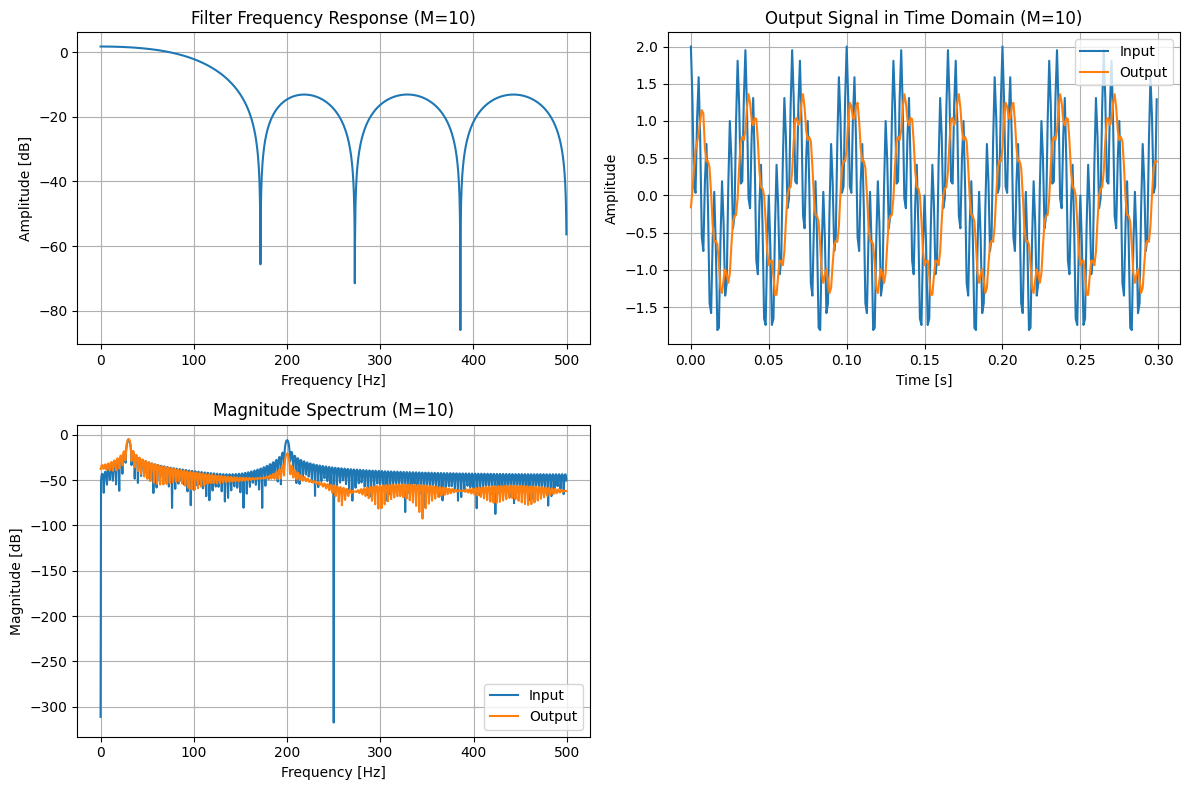

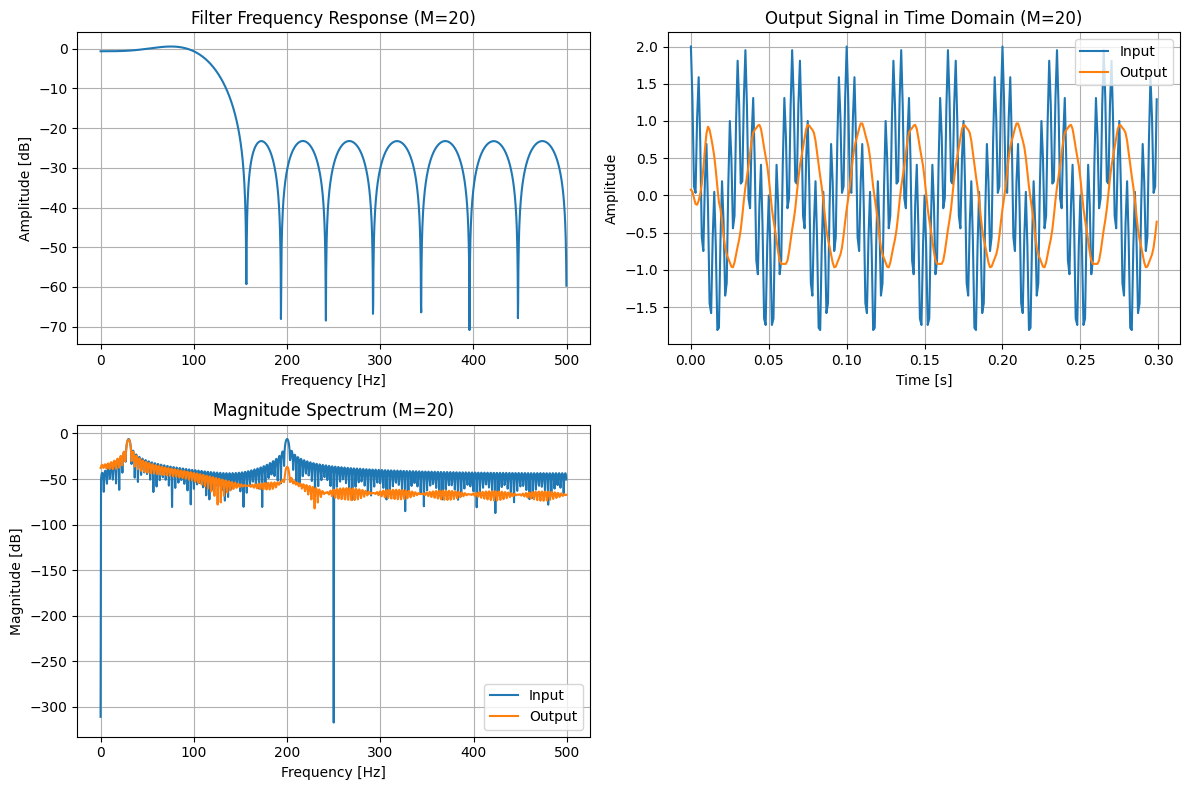

In [5]:
# Sample rate
Fs = 1000  # Hz

# Signal generation
nT = np.arange(0, 300) / Fs
xn = np.cos(2 * np.pi * 30 * nT) + np.cos(2 * np.pi * 200 * nT)

# Function to design filter and plot responses
def analyze_filter(M):
    bands = [0, 100, 150, 500]  # Frequency bands
    desired = [1, 0]  # Desired gain in passband and stopband
    b = signal.remez(M, bands, desired, Hz=1000)
    w, h = signal.freqz(b, [1], worN=2000)

    # Frequency response
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.title(f'Filter Frequency Response (M={M})')
    plt.plot(w * Fs / (2 * np.pi), 20 * np.log10(abs(h)))
    plt.ylabel('Amplitude [dB]')
    plt.xlabel('Frequency [Hz]')
    plt.grid(True)

    # Time-domain response
    y = signal.lfilter(b, [1], xn)
    plt.subplot(2, 2, 2)
    plt.title(f'Output Signal in Time Domain (M={M})')
    plt.plot(nT, xn, label='Input')
    plt.plot(nT, y, label='Output')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    # FFT of the output
    Y = np.fft.fft(y, 2048) / len(y)
    X = np.fft.fft(xn, 2048) / len(xn)
    freq = np.fft.fftfreq(2048, 1 / Fs)

    # Frequency domain plots
    plt.subplot(2, 2, 3)
    plt.title(f'Magnitude Spectrum (M={M})')
    plt.plot(freq[:1024], 20 * np.log10(abs(X[:1024])), label='Input')
    plt.plot(freq[:1024], 20 * np.log10(abs(Y[:1024])), label='Output')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Filter analysis for M=10 and M=20
analyze_filter(10)
analyze_filter(20)


### Discussion

1. **Magnitude Response**: We observe that increasing the filter order improves the stopband attenuation. The M=20 filter has a steeper roll-off and better suppression in the stopband compared to the M=10 filter.

2. **Time-Domain Response**: The output signals show that both filters effectively suppress the higher frequency component (200 Hz), but the M=20 filter achieves a cleaner suppression with less ripple in the passband.

3. **Frequency Domain Response**: In the frequency domain, we see that the M=20 filter provides a more significant attenuation of the 200 Hz component compared to the M=10 filter. This is evident from the lower peak in the output spectrum for the M=20 filter.

4. **Filter Characteristics**: As we increase the filter order, the overall response of the filter improves with sharper cutoffs and better rejection of unwanted frequencies. From our observation, around M=20, the second frequency component (200 Hz) is effectively eliminated, indicating an appropriate choice for this particular application.